In [1]:
!pip install yfinance --quiet
!pip install yahooquery --quiet
!pip install requests_html --quiet
!pip install ydata_profiling --quiet
!pip install PyPortfolioOpt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.9/345.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 24.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 37.1 MB/s et

In [2]:
# Modules imports
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import yfinance as yf
from yahooquery import Screener
import requests
from requests_html import HTMLSession
from datetime import datetime
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting as pt

# The goal
Inspired by the G-Reseach competition in [Kaggle](https://www.kaggle.com/competitions/g-research-crypto-forecasting/overview) and [this portfolio optimizer tool](https://www.portfoliovisualizer.com/optimize-portfolio)

Our aim is to create a Streamlit App to generate, for a given:
  - Porfolio of crypto-currencies.
  - Budget.

The optimized ratio of chosen currencies by maximizing the Sharpe Ratio

We begin the exercice with a step by step guided notebook to cover all the inner working of task completion before wrapping everything in **App.py** script.

# The Data

We'll start with a selection of 5 most popular crypto currencies by market capitalization.

## Getting Data

For scraping historical trading data of the crypto currencies, we rely on Yahoo! finance API.
Fortunatly there is a python [project](https://pypi.org/project/yfinance/) who offers an easy pythonic way to get data.

In [3]:
# Scraping list of 5 most popular crypto tickets (cc)

session = HTMLSession()
num_currencies=5
resp = session.get(f"https://finance.yahoo.com/crypto?offset=0&count={num_currencies}")
tables = pd.read_html(resp.html.raw_html)               
df = tables[0].copy()
cc = df.Symbol.tolist()
cc

['BTC-USD', 'ETH-USD', 'USDT-USD', 'BNB-USD', 'USDC-USD']

In [4]:
# For the given cryptocurrencies, we grab the daily histrical closing price data since 2020:

tickers = yf.Tickers(cc)
end_date = datetime.now().strftime('%Y-%m-%d')
data = tickers.history(start='2020-01-01',end=end_date,interval='1d')['Close']
data

[*********************100%***********************]  5 of 5 completed


,BNB-USD,BTC-USD,ETH-USD,USDC-USD,USDT-USD
Date,,,,,
2020-01-01,13.689083,7200.174316,130.802002,1.004079,0.999836
2020-01-02,13.027011,6985.470215,127.410179,1.005017,1.001565
2020-01-03,13.660452,7344.884277,134.171707,1.005273,1.004192
2020-01-04,13.891512,7410.656738,135.069366,1.009466,1.007472
2020-01-05,14.111019,7411.317383,136.276779,1.008497,1.006197
...,...,...,...,...,...
2023-04-25,338.325562,28307.597656,1866.753662,1.000000,1.000159
2023-04-26,330.821777,28422.701172,1866.564209,0.999884,1.000282
2023-04-27,331.195099,29473.787109,1908.786377,0.999682,0.999965


## Preprocessing Data

In [5]:
# missing data
data.isna().sum()

BNB-USD     0
BTC-USD     0
ETH-USD     0
USDC-USD    0
USDT-USD    0
dtype: int64

In [6]:
data.dtypes

BNB-USD     float64
BTC-USD     float64
ETH-USD     float64
USDC-USD    float64
USDT-USD    float64
dtype: object

In [7]:
#data = data.dropna()

In [8]:
#data.isna().sum()

Other than missing values, it seems there is no issues with observations to handle, we save the downloaded data as a csv file for future exploitation.

# EDA

Having no issues with data, the next step is to explore their main statistical features.

In [9]:
data.describe()

,BNB-USD,BTC-USD,ETH-USD,USDC-USD,USDT-USD
count,1215.000000,1215.000000,1215.000000,1215.000000,1215.000000
mean,247.716533,28453.198776,1687.728497,1.000640,1.000588
std,181.255230,16355.460818,1209.670547,0.004093,0.002550
min,9.386050,4970.788086,110.605873,0.970124,0.974248
25%,28.530214,13602.354004,431.443085,0.999886,1.000021
50%,284.284424,23646.550781,1586.176758,1.000062,1.000261
75%,371.791611,41561.132812,2560.707520,1.000331,1.000798
max,675.684082,67566.828125,4812.087402,1.044029,1.053585


And distributions.

[Text(0.5, 0, 'Tickers'), Text(0, 0.5, 'Closing Price in USD')]

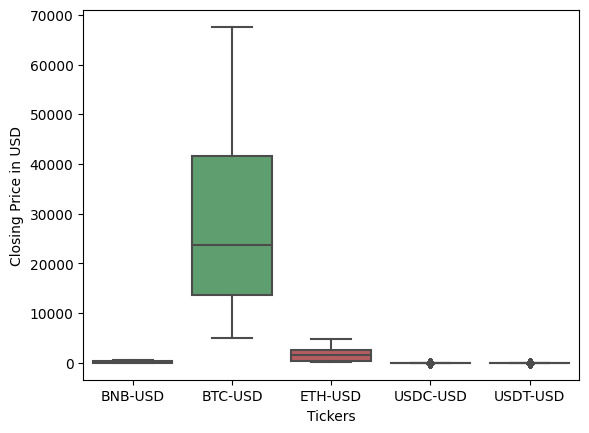

In [138]:
sns.boxplot(data).set(xlabel='Tickers', ylabel='Closing Price in USD')

Switching to logaritimic scale (base 2) for more visibility.

[Text(0.5, 0, 'Tickers'), Text(0, 0.5, 'Closing Price in USD')]

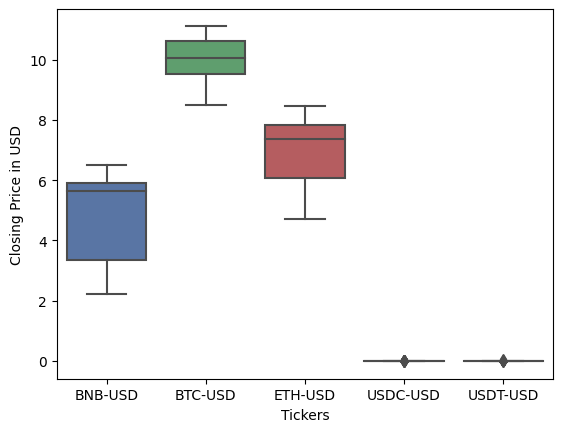

In [139]:
log_data = np.log(data)
sns.boxplot(log_data).set(xlabel='Tickers', ylabel='Closing Price in USD')

It seems we have two groups of currencices.

But before jumping to conclusions, let's inspect the relation between each two currencies.

## Correlation Analysis

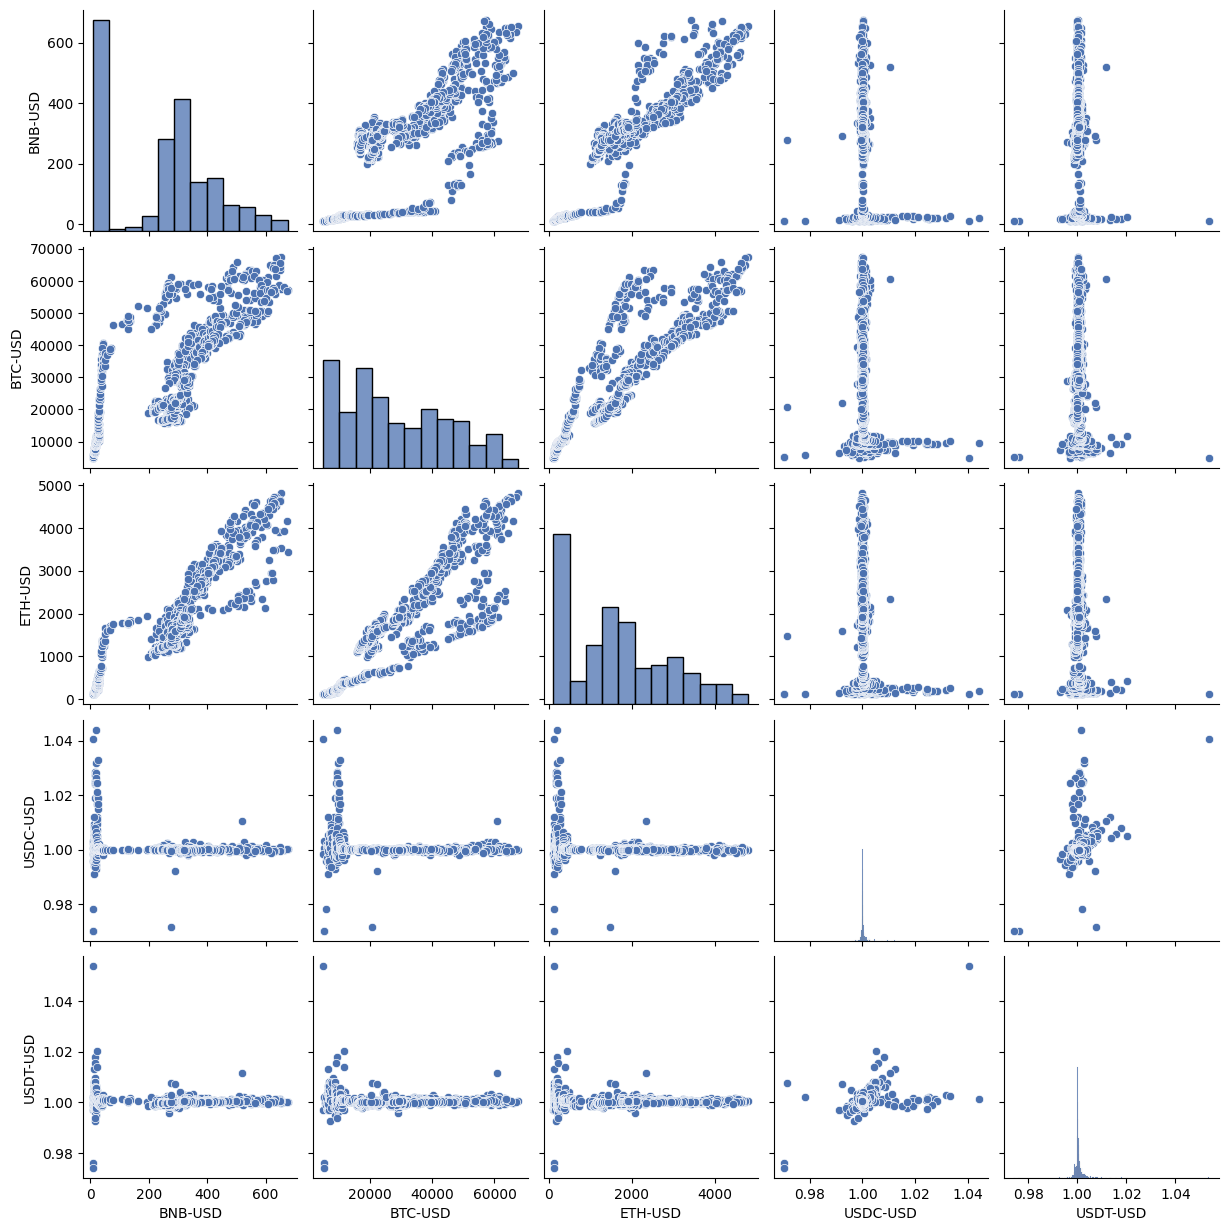

In [140]:
# Ploting each two currencies at a time
sns.pairplot(data)

Text(0.5, 1.0, 'Correlation Heatmap')

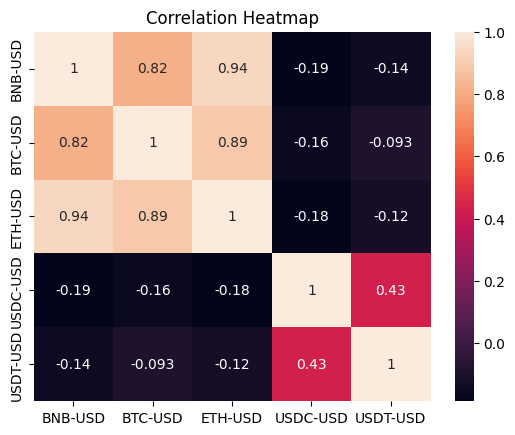

In [141]:
# Calculating and visualizing the correlation between each two currency
corr = data.corr()
sns.heatmap(corr, annot=True).set_title('Correlation Heatmap')

Indeed, two groups of hight and low correlated currencies.

## Volatility Analysis

In finance, mesuring volatilty is assessing how much of a fluctuating an asset is, and the more an asset is volatile, the riskier it is and more difficult to predict.

In [14]:
df = data.copy()

In [15]:
df = np.log(df/df.shift()).rolling(window=365).std()*365**.5

Unlike stock markets where we do specify 252 days of trading per year.

Crypto markets are 24/7 traded throughtout the year.

The choice of 365 days of rolling window is to calculate the annualized volatility.

In [16]:
df = df.dropna()

In [17]:
df

,BNB-USD,BTC-USD,ETH-USD,USDC-USD,USDT-USD
Date,,,,,
2020-12-31,0.974188,0.766632,1.001485,0.106998,0.106501
2021-01-01,0.972838,0.765921,1.001114,0.106994,0.106495
2021-01-02,0.971830,0.769314,1.001467,0.106994,0.106470
2021-01-03,0.974283,0.769468,1.026627,0.106913,0.106420
2021-01-04,0.974236,0.770008,1.028306,0.106909,0.106413
...,...,...,...,...,...
2023-04-25,0.679592,0.615187,0.826775,0.036260,0.008793
2023-04-26,0.678295,0.612391,0.823971,0.036260,0.008794
2023-04-27,0.678112,0.612789,0.823780,0.036260,0.008799


In [18]:
def plot_graph(col,title,xlabel,ylabel,df):
    data = []
    for i in range(len(col)): 
        plot = go.Scatter(x=df.index,y=df[col[i]], name=col[i])
        data.append(plot)
    
    layout = go.Layout(title= title ,
                    xaxis=dict(title=xlabel),
                    yaxis=dict(title=ylabel ), 
                    width = 690, 
                    height = 500, 
                    autosize = True)

    fig = go.Figure(data=data, layout=layout)
    
    fig.show()
    
title = "Annualized Volatility Plot"
xlabel = 'Date'
ylabel = 'Closing price volatility in %'
df = df
col = list(data.columns.values)

plot_graph(col,title,xlabel,ylabel,df)

We Can identify two groups of correlated currencies:


*   Hight Volatility/Positive correlated currencies consisted of:
    1.   BitCoin (BTC)
    2.   Etherium (ETH)
    3.   Binance Coin (BNB)


*   Low Volatility/Negative correlated set of:
    1.   USD Coin (USDC)
    2.   Tether (USDT)


# Modeling
For the modeling section, we rely on Mean-variance optimization (MVO) solution provided by PyPortfolioOpt Library.

The MVO solution is constrained by maximizing the Sharpe ratio which is reputable to indicate how well the risk-ajusted performance a portfolio can be.

The higher the ratio (preferably above 1) the better investment decision is.





In [19]:
# Calculating the mean historical return and covariance matrices
mu = mean_historical_return(data)
S = CovarianceShrinkage(data).ledoit_wolf()

In [20]:
mu

BNB-USD     0.926316
BTC-USD     0.337721
ETH-USD     0.744444
USDC-USD   -0.000848
USDT-USD    0.000159
dtype: float64

In [21]:
S

,BNB-USD,BTC-USD,ETH-USD,USDC-USD,USDT-USD
BNB-USD,0.743641,0.335688,0.453534,-0.002976,-0.005657
BTC-USD,0.335688,0.345567,0.366409,-0.002294,-0.004720
ETH-USD,0.453534,0.366409,0.593613,-0.003625,-0.006362
USDC-USD,-0.002976,-0.002294,-0.003625,0.010088,0.001860
USDT-USD,-0.005657,-0.004720,-0.006362,0.001860,0.009818


The risk free market is corresponding to the US Federal Reserve Interest Rate (its a choice)

In [150]:
# Scrapping the current FED interest rate:
all_data = pd.read_html('https://www.global-rates.com/en/interest-rates/central-banks/central-bank-america/fed-interest-rate.aspx')
FED = [df for df in all_data if df.iloc[0][0] == 'American interest rate (Fed)'][0].iloc[0][1]
# Formating into float
FED = float(FED[:5])/100

In [147]:
FED

0.05

In [24]:
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe(risk_free_rate= FED)
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

OrderedDict([('BNB-USD', 0.63303), ('BTC-USD', 0.0), ('ETH-USD', 0.36697), ('USDC-USD', 0.0), ('USDT-USD', 0.0)])


In [25]:
ef.portfolio_performance(verbose=True, risk_free_rate = FED)

Expected annual return: 86.0%
Annual volatility: 76.7%
Sharpe Ratio: 1.06


(0.8595740485099208, 0.7672361760225858, 1.0551823203994601)

# Insights Visualization

This section is preliminary implementation of portfolio backtesting.

But first, let explore visually the optimization results in terms of efficients frontier vis-a-vis a randomized set of portfolios.

## Modeling Results

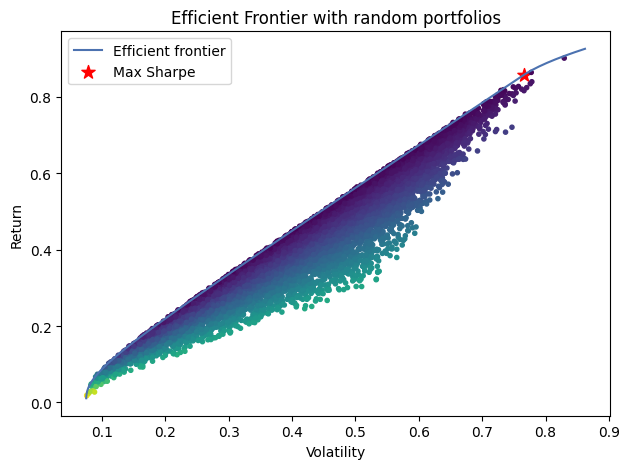

In [26]:
fig, ax = plt.subplots()
ef = EfficientFrontier(mu, S)
pt.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef = EfficientFrontier(mu, S)
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

Again, The maximized Sharpe-Ratio (which is an indication of how well the risk-ajusted performance a portfolio can be) is corresponding to a Portfolio with the following ratios:

In [30]:
# Optimized Portfolio ratios 

labels = cleaned_weights.keys()
sizes = cleaned_weights.values()

optimized_portfolio = pd.DataFrame([i for i in zip(labels, sizes)], columns=['Tickers','Ratio'])
optimized_portfolio

,Tickers,Ratio
0,BNB-USD,0.63303
1,BTC-USD,0.00000
2,ETH-USD,0.36697
3,USDC-USD,0.00000
4,USDT-USD,0.00000


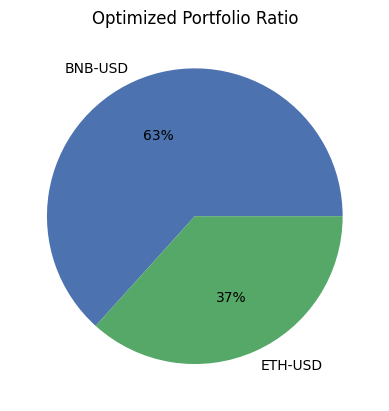

In [35]:
# Optimized Portfolio ratios

# eliminate the zero ratios
labels = [i for i in cleaned_weights.keys() if cleaned_weights[i] != 0]
sizes = [i for i in cleaned_weights.values() if i != 0]

plt.title('Optimized Portfolio Ratio')
plt.pie(sizes, labels=labels, autopct='%.0f%%')
plt.show()

## Portfolio Perfomance

In [ ]:
# https://www.codingfinance.com/post/2018-04-05-portfolio-returns-py/
# https://www.allthesnippets.com/notes/finance/calculating_cumulative_returns_of_stocks_with_python_and_pandas.html

### Optimized Portfolio

In [38]:
ratios = [i for i in cleaned_weights.values()]

In [39]:
ratios

[0.63303, 0.0, 0.36697, 0.0, 0.0]

In [41]:
sum(ratios)

1.0

In [42]:
returns = data.pct_change()[1:]
returns

,BNB-USD,BTC-USD,ETH-USD,USDC-USD,USDT-USD
Date,,,,,
2020-01-02,-0.048365,-0.029819,-0.025931,0.000934,0.001729
2020-01-03,0.048625,0.051452,0.053069,0.000255,0.002623
2020-01-04,0.016915,0.008955,0.006690,0.004171,0.003266
2020-01-05,0.015802,0.000089,0.008939,-0.000960,-0.001266
2020-01-06,0.060009,0.048291,0.058905,-0.005333,-0.003274
...,...,...,...,...,...
2023-04-25,0.021373,0.028420,0.013022,-0.000042,0.000038
2023-04-26,-0.022179,0.004066,-0.000101,-0.000116,0.000123
2023-04-27,0.001128,0.036981,0.022620,-0.000202,-0.000317


In [101]:
portfolio_returns = (ratios * returns).sum(axis=1)
portfolio_returns

Date
2020-01-02   -0.040132
2020-01-03    0.050256
2020-01-04    0.013163
2020-01-05    0.013283
2020-01-06    0.059604
                ...   
2023-04-25    0.018308
2023-04-26   -0.014077
2023-04-27    0.009015
2023-04-28   -0.015925
2023-04-29   -0.001434
Length: 1214, dtype: float64

<Axes: xlabel='Date'>

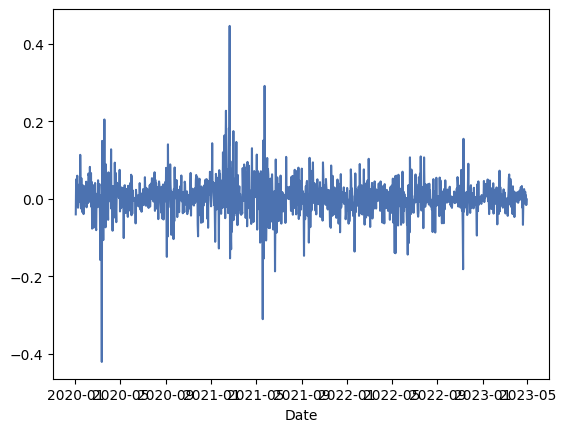

In [102]:
sns.lineplot(portfolio_returns)

In [104]:
portfolio_returns.describe()

count    1214.000000
mean        0.003828
std         0.048722
min        -0.420670
25%        -0.017495
50%         0.003478
75%         0.026302
max         0.445907
dtype: float64

In [105]:
portfolio_cum_returns = (1 + portfolio_returns).cumprod() - 1
portfolio_cum_returns

Date
2020-01-02    -0.040132
2020-01-03     0.008107
2020-01-04     0.021376
2020-01-05     0.034943
2020-01-06     0.096630
                ...    
2023-04-25    23.658268
2023-04-26    23.311146
2023-04-27    23.530318
2023-04-28    23.139676
2023-04-29    23.105067
Length: 1214, dtype: float64

<Axes: xlabel='Date'>

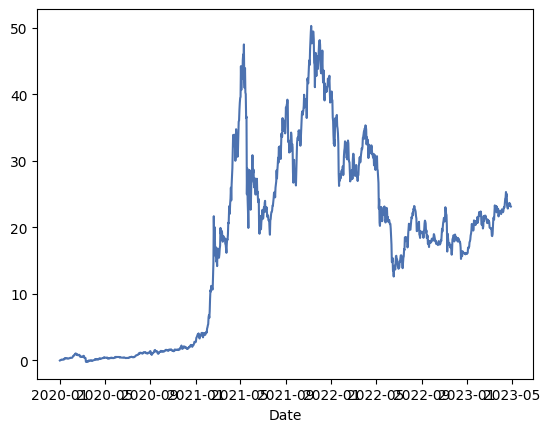

In [106]:
sns.lineplot(portfolio_cum_returns)

### Benchmark Portfolio

In [53]:
# Benchmark portfolio
b_weights = [round(1/len(cc), 2) for i in cc]
b_weights

[0.2, 0.2, 0.2, 0.2, 0.2]

In [108]:
b_weighted_portfolio = (data * b_weights)
b_weighted_portfolio

,BNB-USD,BTC-USD,ETH-USD,USDC-USD,USDT-USD
Date,,,,,
2020-01-01,2.737817,1440.034863,26.160400,0.200816,0.199967
2020-01-02,2.605402,1397.094043,25.482036,0.201003,0.200313
2020-01-03,2.732090,1468.976855,26.834341,0.201055,0.200838
2020-01-04,2.778302,1482.131348,27.013873,0.201893,0.201494
2020-01-05,2.822204,1482.263477,27.255356,0.201699,0.201239
...,...,...,...,...,...
2023-04-25,67.665112,5661.519531,373.350732,0.200000,0.200032
2023-04-26,66.164355,5684.540234,373.312842,0.199977,0.200056
2023-04-27,66.239020,5894.757422,381.757275,0.199936,0.199993


In [109]:
b_weighted_portfolio_returns = b_weighted_portfolio.pct_change()[1:].sum(axis=1)

In [110]:
b_weighted_portfolio_returns

Date
2020-01-02   -0.101452
2020-01-03    0.156023
2020-01-04    0.039997
2020-01-05    0.022604
2020-01-06    0.158599
                ...   
2023-04-25    0.062810
2023-04-26   -0.018207
2023-04-27    0.060210
2023-04-28   -0.032326
2023-04-29   -0.001756
Length: 1214, dtype: float64

<Axes: xlabel='Date'>

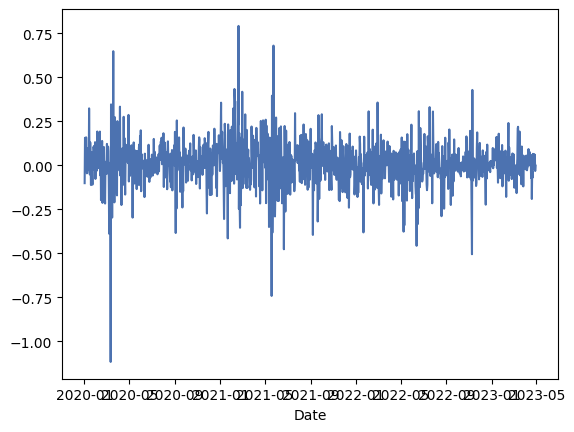

In [111]:
sns.lineplot(b_weighted_portfolio_returns)

In [112]:
b_weighted_portfolio_returns.describe()

count    1214.000000
mean        0.009356
std         0.126306
min        -1.116017
25%        -0.048259
50%         0.011391
75%         0.074018
max         0.790947
dtype: float64

In [113]:
b_weighted_portfolio_cum_returns = (1 + b_weighted_portfolio_returns).cumprod() - 1

In [114]:
b_weighted_portfolio_cum_returns

Date
2020-01-02   -0.101452
2020-01-03    0.038743
2020-01-04    0.080290
2020-01-05    0.104709
2020-01-06    0.279914
                ...   
2023-04-25   -3.209764
2023-04-26   -3.169530
2023-04-27   -3.300158
2023-04-28   -3.225802
2023-04-29   -3.221893
Length: 1214, dtype: float64

<Axes: xlabel='Date'>

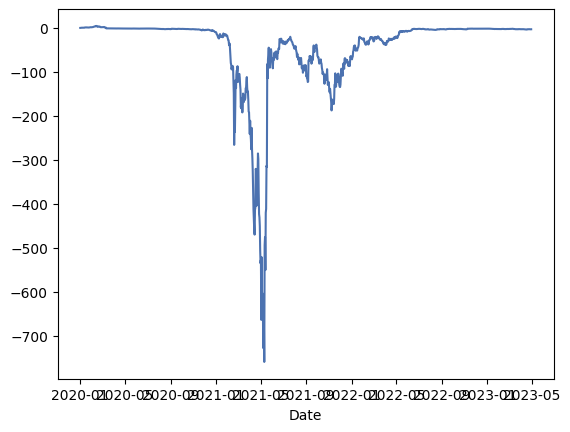

In [115]:
sns.lineplot(b_weighted_portfolio_cum_returns)

### Performance Comparaison

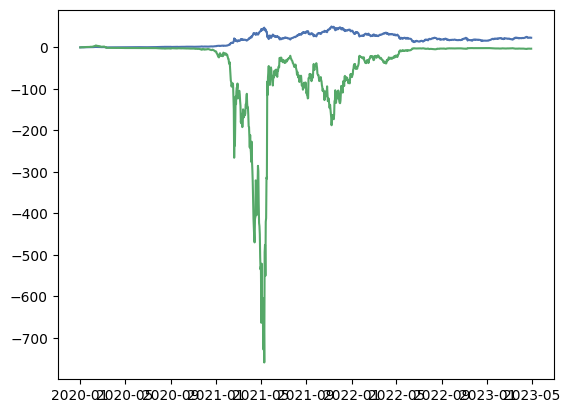

In [67]:
plt.subplot()
plt.plot(portfolio_cum_returns)
plt.plot(b_weighted_portfolio_cum_returns)
plt.show()

In [124]:
# Performance with budget
budget = float(input('Input your initial investement: '))

Input your initial investement: 1000


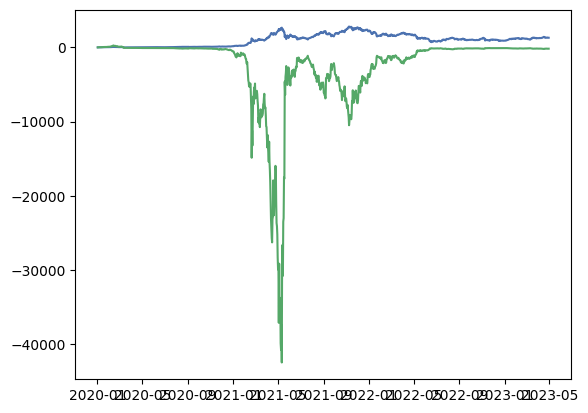

In [122]:
# Cumulative Returns with budget
plt.subplot()
plt.plot(portfolio_cum_returns * budget)
plt.plot(b_weighted_portfolio_cum_returns * budget)
plt.show()

In [151]:
# Portfolio value:
rslt_opt = portfolio_cum_returns[-1] * budget
rslt_ben = b_weighted_portfolio_cum_returns[-1] * budget

print(f'With initial budget of USD {round(budget, 2)}, we get a cumulative return of: \n',
      'Optimized Portfolio: USD ', round(rslt_opt, 2), 
      '\n Benchmark Portfolio: USD ',round(rslt_ben, 2))

With initial budget of USD 1000.0, we get a cumulative return of: 
 Optimized Portfolio: USD  23105.07 
 Benchmark Portfolio: USD  -3221.89


# Streamlit App

Wrapping all previous steps into a Streamlit App

In [ ]:
# Template
# https://streamlit-example-app-download-app-lk16x1.streamlit.app/

# Design
"""
Title [CryptoPortOpt] AKA Crypto Currencies Porfolio' Optimizer

Step1: Select Your Porfolio
  -> The user will be provider with a list of  10 most popular
  crypto by market cap

Step2: Budget(Optional)
  ->  Default to 1000 USA for Porfolio Performation 
  visualizations

Step3: Optimize using MVO/PyPortOpt
  -> Maximize Sharpe Ratio
  Or
  -> Minimise Volatility

Step4: Results/Visualisation
  -> Asset Allocations
  -> Portfolio Performance
"""

In [ ]:
# modules required to run the App
%%writefile requirements.txt
pandas
matplotlib
seaborn
numpy
yfinance
yahooquery
requests
requests_html
datetime
pypfopt

In [ ]:
#%%writefile app.py


# Conclusion

Beyond the App
- Portfolio builder App

# References
[Getting Crypto Symbols](https://stackoverflow.com/a/74656748)

[Portfolio Optimization Using Python](https://github.com/areed1192/portfolio-optimization/blob/master/samples/portfolio_optimization.ipynb)

[Portfolio Builder](https://github.com/yeungadrian/PortfolioBuilder)

[Portfolio Selection with Graph Algorithms and Deep Learning](https://www.linkedin.com/pulse/portfolio-selection-graph-algorithms-deep-learning-maya-benowitz)

[G-Research Crypto Forecasting](https://www.kaggle.com/competitions/g-research-crypto-forecasting/overview)

[G-Research Crypto Forecasting](https://www.kaggle.com/code/cstein06/tutorial-to-the-g-research-crypto-competition/notebook#Preprocessing)

[yfinance guide](https://www.qmr.ai/yfinance-library-the-definitive-guide/#Fetch_Historical_Prices_using_yfinance
)

[Portfolio Optimization with PyPortfolioOpt](https://github.com/paulsg3/PortfolioOptimization/blob/main/Portfolio_Optimization.ipynb)

[PyPortfolioOpt Documentation](https://pyportfolioopt.readthedocs.io/en/latest/)

[Portfolio Optimization using Reinforcement Learning](https://github.com/kvsnoufal/portfolio-optimization)

[Multi-level Columns](https://stackoverflow.com/a/56080234)

[On the non-stationarity of financial time series: Impact on optimal portfolio selection](https://www.researchgate.net/publication/224905259_On_the_non-stationarity_of_financial_time_series_Impact_on_optimal_portfolio_selection)

[Stationary TS](https://analyticsindiamag.com/how-to-make-a-time-series-stationary/)

[Volatility Analysis](https://www.learnpythonwithrune.org/calculate-the-volatility-of-historic-stock-prices-with-pandas-and-python/)

[Volatility Analysis](https://blog.quantinsti.com/volatility-and-measures-of-risk-adjusted-return-based-on-volatility/)

[Sharpe Ratio](https://www.investopedia.com/terms/s/sharperatio.asp)

[Mean-variance Optimization](https://www.investopedia.com/terms/m/meanvariance-analysis.asp)

[Backtesting](https://gist.github.com/jatinkathiriya/ca9063711316d9b7c3cbd993b8c6656b#file-portfolio-backtesting-ipynb)